In [48]:
%matplotlib notebook
%matplotlib inline 

##Import des packages

In [2]:
! pip install unidecode
! pip install nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re

from pandas_profiling import ProfileReport
import unidecode
import nltk
from string import punctuation

nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize

import os
from sklearn.utils import shuffle
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import unicodedata

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Importer les données
- Importer tous les discours
- Créer un dataframe rassemblant tous les discours par ville et par date
Nettoyer les données



##Import des données

In [3]:
from google.colab import drive
drive.mount('/content/drive')
liste_discours=["Agen_Z.csv",'Villepinte_Z.csv','Calais_Z.csv','Cannes_Z.csv','Chambery_Z.csv','Chateaudun_Z.csv','Lille_Z.csv',
                'Montsaintmichel_Z.csv','Sables_dolonnes_Z.csv','Saintquentin_Z.csv','Saulieu_Z.csv','Sologne_Z.csv',"Toulon_Z.csv","Femmes_Z.csv",
                "Presse_Z.csv","Défense_Z.csv","Trocadero_Z.csv"]

### Constitution de la base de données totale: on crée une ligne par discours


dico_Z={}

for discours in liste_discours:
  df = pd.read_csv("/content/drive/MyDrive/Bases_NLP/"+discours,sep=';',encoding="windows-1252", engine='python') #, error_bad_lines=False)
  
  
  
  #contenu = df.content.drop_duplicates().apply(lambda x: x.split(' ')).array
  contenu_init = df.content.apply(lambda x: x.replace("?",""))
  contenu=contenu_init.apply(lambda x: x.split(' ')).array
    
  flat_list = itertools.chain(*contenu)
  flat_list=list(flat_list)

  texte = '' 
  for val in flat_list:

    texte += "".join(str(val))+" "

  dico_Z[discours]=texte

base_recapitulative=pd.DataFrame(dico_Z.values(),dico_Z.keys())
base_recapitulative.rename(columns={0:"Discours"},inplace=True)
base_recapitulative["Lieu"]=base_recapitulative.index.str.split("_")
base_recapitulative["Lieu"]=base_recapitulative.index.str.split("_").array
base_recapitulative

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Discours,Lieu
Agen_Z.csv,Bonjour Agen ! Bonjour mes chers amis ! Bonjou...,"[Agen, Z.csv]"
Villepinte_Z.csv,"Bonjour a tous, bonjour mes amis… Merci de vot...","[Villepinte, Z.csv]"
Calais_Z.csv,"Bonjour à tous, merci pour votre présence. Nou...","[Calais, Z.csv]"
Cannes_Z.csv,"Merci, mes amis, merci ! Du fond du cœur ! Vot...","[Cannes, Z.csv]"
Chambery_Z.csv,"Bonjour, chers amis ! Bonjour et merci, merci...","[Chambery, Z.csv]"
Chateaudun_Z.csv,"Mes chers amis, mesdames et messieurs les élus...","[Chateaudun, Z.csv]"
Lille_Z.csv,"Bonjour à tous, chers amis ! Quel plaisir d’êt...","[Lille, Z.csv]"
Montsaintmichel_Z.csv,"Chers amis ! Nous avons bravé le froid, nous a...","[Montsaintmichel, Z.csv]"
Sables_dolonnes_Z.csv,"Bonjour à tous ! Merci beaucoup, merci… Décidé...","[Sables, dolonnes, Z.csv]"
Saintquentin_Z.csv,"Bonjour à tous, bonjour mes amis ! Quelle pass...","[Saintquentin, Z.csv]"


In [4]:
### Base à compléter à la main pour les dimensions géographiques, démographiques et temporelles

base_recapitulative["Ville"]=[i[0] for i in base_recapitulative.index.str.split("_").array]
#base_recapitulative["Coordonnées"]=""
#base_recapitulative["Date"]=""
del base_recapitulative["Lieu"]
base_recapitulative.reset_index(drop=True,inplace=True)
base_recapitulative.to_csv("Base_totale_Z.csv")

bvc=base_recapitulative.copy()

#Données et nettoyages

## Ajout des dates dates et coordonnées 

In [5]:
df=pd.DataFrame(base_recapitulative)
vvv=['03/12/2022',
' 12/05/2021  ',
' 01/19/2022  ',
' 01/23/2022  ',
' 02/25/2022  ',
' 01/07/2022  ',
' 02/05/2022  ',
' 02/19/2022  ',
' 01/08/2022  ',
' 01/15/2022   ',
' 02/12/2022  ',
' 01/28/2022  ',
' 03/06/2022  ',
'03/08/2022',
'01/10/2022',
'02/17/2022',
'03/27/2022']

df['date']=vvv
## Division de la date 

df['date'] = pd.to_datetime(df['date'])
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['month'] = df['date'].dt.month
df['year']=df['date'].dt.year

df

,Discours,Ville,date,day,weekday,month,year
0,Bonjour Agen ! Bonjour mes chers amis ! Bonjou...,Agen,2022-03-12,12,5,3,2022
1,"Bonjour a tous, bonjour mes amis… Merci de vot...",Villepinte,2021-12-05,5,6,12,2021
2,"Bonjour à tous, merci pour votre présence. Nou...",Calais,2022-01-19,19,2,1,2022
3,"Merci, mes amis, merci ! Du fond du cœur ! Vot...",Cannes,2022-01-23,23,6,1,2022
4,"Bonjour, chers amis ! Bonjour et merci, merci...",Chambery,2022-02-25,25,4,2,2022
5,"Mes chers amis, mesdames et messieurs les élus...",Chateaudun,2022-01-07,7,4,1,2022
6,"Bonjour à tous, chers amis ! Quel plaisir d’êt...",Lille,2022-02-05,5,5,2,2022
7,"Chers amis ! Nous avons bravé le froid, nous a...",Montsaintmichel,2022-02-19,19,5,2,2022
8,"Bonjour à tous ! Merci beaucoup, merci… Décidé...",Sables,2022-01-08,8,5,1,2022
9,"Bonjour à tous, bonjour mes amis ! Quelle pass...",Saintquentin,2022-01-15,15,5,1,2022


In [6]:
from tkinter import *
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="MyApp")
!pip install pgeocode
##import pgeocode
##!pip install geopandas

In [7]:
#Ajout des coordonées de localisation du lieu du discours
base_recapitulative2=base_recapitulative.copy()

list_ville=base_recapitulative2.Ville.drop(labels=[13,14,15])
list_ville1=list_ville
list_ville[7]="Mont-Saint-Michel"
list_ville[8]="Les Sables-d’Olonne"
list_ville[9]="Saint-Quentin"
list_ville[11]="Chaumont-sur-Tharonne"
list_ville[13]="Paris"
kp=[]
kp1=[]

for i in list_ville:
  print(i)
  location = geolocator.geocode(i)
  kp.append(location.longitude)
  kp1.append(location.latitude)

df2=pd.DataFrame()
df2["Ville"]=list_ville1
df2["longitude"]=kp
df2["latitude"]=kp1

df3=df.merge(df2,how="left",on="Ville")
base_recapitualtive=df3.copy()

Agen
Villepinte
Calais
Cannes
Chambery
Chateaudun
Lille
Mont-Saint-Michel
Les Sables-d’Olonne
Saint-Quentin
Saulieu
Chaumont-sur-Tharonne
Toulon
Trocadero
Paris


## Nettoyage des données

In [8]:
### Travail préliminaire

### Nous retirons les mots inutiles
stopwords_ = stopwords.words('french')

#autres_stopwords=["ni","était","si","car","cette","plus","alors","chaque","a","quel","quelque","chacun","parce","\’", "\«", "\»"]
french_stopwords=set(list(stopwords_)+list(punctuation))



### Transformation en texte

def Transformation_texte(flatlist):
  """
  Cette fonction permet de transformer une liste de mots en texte
  """
  texte = '' 
  for val in flatlist:

    #texte += "".join(unidecode.unidecode(val))+" "
    texte += "".join(unidecode.unidecode(val))+" "
  return(texte)

#texte_df=Transformation_texte(flat_list)  



def Retirer_mots_inutiles(texte_brut):
  """
  Cette fonction permet de nettoyer un texte des mots superflus 
  """
  filtre_stopfr =  lambda text: [token for token in text if token.lower() not in french_stopwords]


  texte_filtre=filtre_stopfr(word_tokenize(texte_brut, language="french") )
  texte = '' 
  for val in texte_filtre:

    texte += "".join(str(val))+" "


  return(texte)

#Retirer_mots_inutiles(texte_df)

###Choix de tokenization

In [9]:
### Nous voulons comparer différentes de méthodes de tokenization pour choisir celle qui est la plus appropriée

Dictionnaire_token={}


### Méthode 1: mous créons une liste de chaque mot du texte
for discours in liste_discours:
  df = pd.read_csv("/content/drive/MyDrive/Bases_NLP/"+discours,sep=';',encoding="windows-1252", engine='python')
contenu = df.content.drop_duplicates().apply(lambda x: x.split(' ')).array
contenu_init = df.content.apply(lambda x: x.replace("?",""))
contenu=contenu_init.apply(lambda x: x.split(' ')).array

flat_list = itertools.chain(*contenu)
flat_list=list(flat_list)
Dictionnaire_token["Liste"]=flat_list

### Méthode 2: tokenization

from nltk.tokenize import TreebankWordTokenizer
from nltk.tokenize import ToktokTokenizer
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

#
tokenizers = [TreebankWordTokenizer(), ToktokTokenizer(), TweetTokenizer(),RegexpTokenizer(r'\w+')]
nom_tok=["treebank","toktok","tweet","regexp"]
import pdb # python debugger

nb=0
for tok in tqdm(tokenizers):
  print('Using tokenizer: %s' % (tok))
  #contenu = df.content.drop_duplicates().apply(lambda x: x.split(' ')).array
  contenu_init = df.content.apply(lambda x: x.replace("?",""))
  arr=contenu_init.apply(lambda x: tok.tokenize(x)).array

  #arr = df.content.drop_duplicates().apply(lambda x: tok.tokenize(x)).array
  # We flatten the list. We could use this : arr = reduce(add, arr)   but it would take too much time.
  flat_list = [ x for X in arr for x in X]
  Dictionnaire_token[nom_tok[nb]]=flat_list
  nb+=1

  0%|          | 0/4 [00:00<?, ?it/s]

Using tokenizer: <nltk.tokenize.treebank.TreebankWordTokenizer object at 0x7f4b0c0dfa10>
Using tokenizer: <nltk.tokenize.toktok.ToktokTokenizer object at 0x7f4b0c02a410>
Using tokenizer: <nltk.tokenize.casual.TweetTokenizer object at 0x7f4b0c025350>
Using tokenizer: RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)


In [10]:
list(Dictionnaire_token.keys())


['Liste', 'treebank', 'toktok', 'tweet', 'regexp']

In [11]:
### On veut créer un dictionnaire associant pour chaque méthode de tokenization le texte tokenisé


nb=0
### Nettoyage des discours
Dictionnaire_texte={}
Textes=[]

for methode in Dictionnaire_token.keys():
  flatliste_methode=Dictionnaire_token[methode]
  t1=Transformation_texte(flatliste_methode)
  t2=Retirer_mots_inutiles(t1)
  Textes.append(t2)

texte1,texte2,texte3,texte4,texte5=[Textes[i] for i in range(5)]


In [49]:
### Vérifier que les mots qui apparaissent le plus souvent ne sont pas des mots parasites

from collections import Counter
items=[i for i in texte5.split(" ") if len(i)>1]
counts = Counter(items)
pd.DataFrame(counts.values(),counts.keys()).sort_values(by=0,ascending=False)[0:30].T.columns

Index(['France', 'pays', 'plus', 'Francais', 'veux', 'cette', 'etes', 'tous',
       'etre', 'parce', 'Trocadero', 'fait', 'dire', 'verite', 'Alors',
       'parle', 'quand', 'faire', 'enfants', 'appelle', 'Etat', 'hui', 'amis',
       'tout', 'devant', 'francais', 'aujourd', 'ceux', 'jamais', 'ans'],
      dtype='object')

In [50]:
texte2,texte3,texte4,texte5

(' chers amis  quelle joie quel bonheur  quelle foule  quel ciel  quelle esperance   voici   etes      francais   reculent devant rien    francais   fiers   pays   francais  veulent ecrire histoire   voici   etes   reunis sous  ciel bleu  paris   etes venus  toutes  villes   tous  villages  france   sais  certains  meme venus  outre mer   etranger   sais   milliers  policiers  militaires   gendarmes  venus  civil  quatre coins  france   veux    rendions hommage   chers amis  etes    trocadero   etes  millions partout  france  metropole   outre mer  a etranger a  suivre aujourd hui parce  fond    sentez   ici  ecrit histoire   chers amis   pensaient    viendriez    pensaient   etiez resignes    etes    voulaient  dire   scenario   prepare depuis  ans etait  train  accomplir   etes      connaissaient     connaissent  insolence   peuple  liberte  francais  volonte ecrire histoire    dit      candidat   dit    depasserai        parrainages      parti    militants   tout dit     trompes  to

Les 4 méthodes de tokenisation obtiennent des résultats très similaires mais nous préférons la dernière méthode car elle semble retirer le plus de mots superflus

In [51]:
T=[texte2,texte3,texte4,texte5]
[len(i) for i in T]

[25843, 14588, 25843, 22719]

###Nettoyage automatisé

Choix de la tokenization par Rexexp: c'est celle qui élimine le plus de mots superflus

In [52]:
def lemmatization(lemmatizer,sentence):
    lem = [lemmatizer.lemmatize(k) for k in sentence]
    lem = set(lem)
    return [k for k in lem]

def remove_stop_words(stopwords_list,sentence):
    return [k for k in sentence if k not in stopwords_list]

def preprocessed_rallies(rallies):
    updated_rallies = []
    for rallie in rallies:
        lemmatizer = WordNetLemmatizer()
        tokenizer = RegexpTokenizer(r'\w+')
        stopwords_list = stopwords.words('french')
        rallie = rallie.lower()
        remove_punc = tokenizer.tokenize(rallie) # Remove puntuations
        remove_num = [re.sub('[0-9]', '', i) for i in remove_punc] # Remove Numbers
        remove_num = [i for i in remove_num if len(i)>0] # Remove empty strings
        lemmatized = lemmatization(lemmatizer,remove_num) # Word Lemmatization
        remove_stop = remove_stop_words(stopwords_list,lemmatized) # remove stop words
        updated_rallie = ' '.join(remove_stop)
        updated_rallies.append(updated_rallie)
    return np.array(updated_rallies)

def get_data(Texts):
    preprocessed_texts = preprocessed_rallies(Texts)
    return preprocessed_texts


def preprocessed_text(rallies):
    """
    Cette fonction permet de nettoyer un texte sous forme de liste en retirant les stopwords, les chiffres etc...

    """
    updated_rallies = []
    for rallie in rallies:
        #lemmatizer = WordNetLemmatizer()
        tokenizer = RegexpTokenizer(r'\w+')
        stopwords_list = stopwords.words('french')
        rallie = rallie.lower()
        remove_punc = tokenizer.tokenize(rallie) # Remove puntuations
        remove_num = [re.sub('[0-9]', '', i) for i in remove_punc] # Remove Numbers
        remove_num = [i for i in remove_num if len(i)>0] # Remove empty strings
        #lemmatized = lemmatization(lemmatizer,remove_num) # Word Lemmatization
        remove_stop = remove_stop_words(stopwords_list,remove_num) # remove stop words
        updated_rallie = ' '.join(remove_stop)
        updated_rallies.append(updated_rallie)
    return " ".join(updated_rallies)

#### Retirer les verbes

On veut retirer les verbes pour se concentrer uniquement les noms communs ou les noms propres, voire quelques adverbes. Cependant le tagging est trop peu précis pour être utilisé de façon adéquate.

In [53]:
nltk.download('averaged_perceptron_tagger')


tokens= RegexpTokenizer(r'\w+').tokenize(texte5)
tagged = nltk.pos_tag(tokens)
tokens[0]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


'chers'

Nous voyons ici que de nombreux que l'on souhaiterait conserver sont en fait classifiés comme verbe

In [54]:
mots=[tagged[i][0] for i in range(len(tagged))]
classification=[tagged[i][1] for i in range(len(tagged))]

df_class=pd.DataFrame({"Mots":mots,"Classification":classification})
print(df_class["Classification"].unique())
df_class["Mots"].loc[df_class["Classification"].isin(['VBP'])].unique()

['NNS' 'VBP' 'NNP' 'NN' 'VBZ' 'CD' 'VBD' 'JJ' 'FW' 'DT' 'IN' 'CC' 'RB'
 'JJR' 'VB' 'RBR' 'MD' 'NNPS' 'RP' 'EX' 'PRP' 'RBS']


array(['amis', 'villes', 'meme', 'venus', 'partout', 'etait', 'train',
       'peuple', 'releve', 'plusieurs', 'dis', 'besoin', 'accueillerai',
       'droite', 'prete', 'Quant', 'pouvoir', 'quel', 'pays', 'disent',
       'toujours', 'etre', 'pensez', 'seuls', 'autour', 'monde', 'fond',
       'destinait', 'bas', 'allait', 'decide', 'salut', 'peut', 'deplu',
       'passe', 'passee', 'laquelle', 'dire', 'fait', 'avenir', 'celui',
       'bien', 'vie', 'hommage', 'oublierai', 'enleve', 'parce', 'quand',
       'concepts', 'subissez', 'enfant', 'revolte', 'veux', 'Alors',
       'comme', 'restant', 'venu', 'faire', 'mourir', 'satisfait',
       'resistants', 'gigantesques', 'lequel', 'devoir', 'memes',
       'aujourd', 'cru', 'aime', 'construit', 'parle', 'peur', 'vieux',
       'propose', 'comptent', 'aiderai', 'impots', 'trop', 'veufs',
       'retrouverez', 'travail', 'porteront', 'heureux', 'entreprise',
       'sentez', 'contre', 'reve', 'greve', 'paperasse', 'ruine',
       'sacc

In [55]:
### Nous reprenons la base totale complétée

for i in base_recapitulative.index:
  discours=base_recapitulative["Discours"].loc[i]
  base_recapitulative.loc[i,"Discours"]=preprocessed_text(discours.split(" "))
base_recapitulative.head()  

,Discours,Ville,date,day,weekday,month,year
0,bonjour agen bonjour chers amis bonjour nou...,Agen,2022-03-12,12,5,3,2022
1,bonjour a tous bonjour amis merci accueil ...,Villepinte,2021-12-05,5,6,12,2021
2,bonjour tous merci présence ici calais d...,Calais,2022-01-19,19,2,1,2022
3,merci amis merci fond cœur presence joi...,Cannes,2022-01-23,23,6,1,2022
4,bonjour chers amis bonjour merci merci mille...,Chambery,2022-02-25,25,4,2,2022


#Statistiques descriptives et démarche exploratoire

### Bigrams

In [56]:
#Impportation des librairies pour le texte
import glob
from wordcloud import STOPWORDS
import seaborn as sns
from datetime import datetime



#Importation des librairies pour les bigrams et l'analyse de sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.util import bigrams
from nltk.util import ngrams

from nltk import FreqDist
from nltk.collocations import *
from nltk.draw.dispersion import dispersion_plot

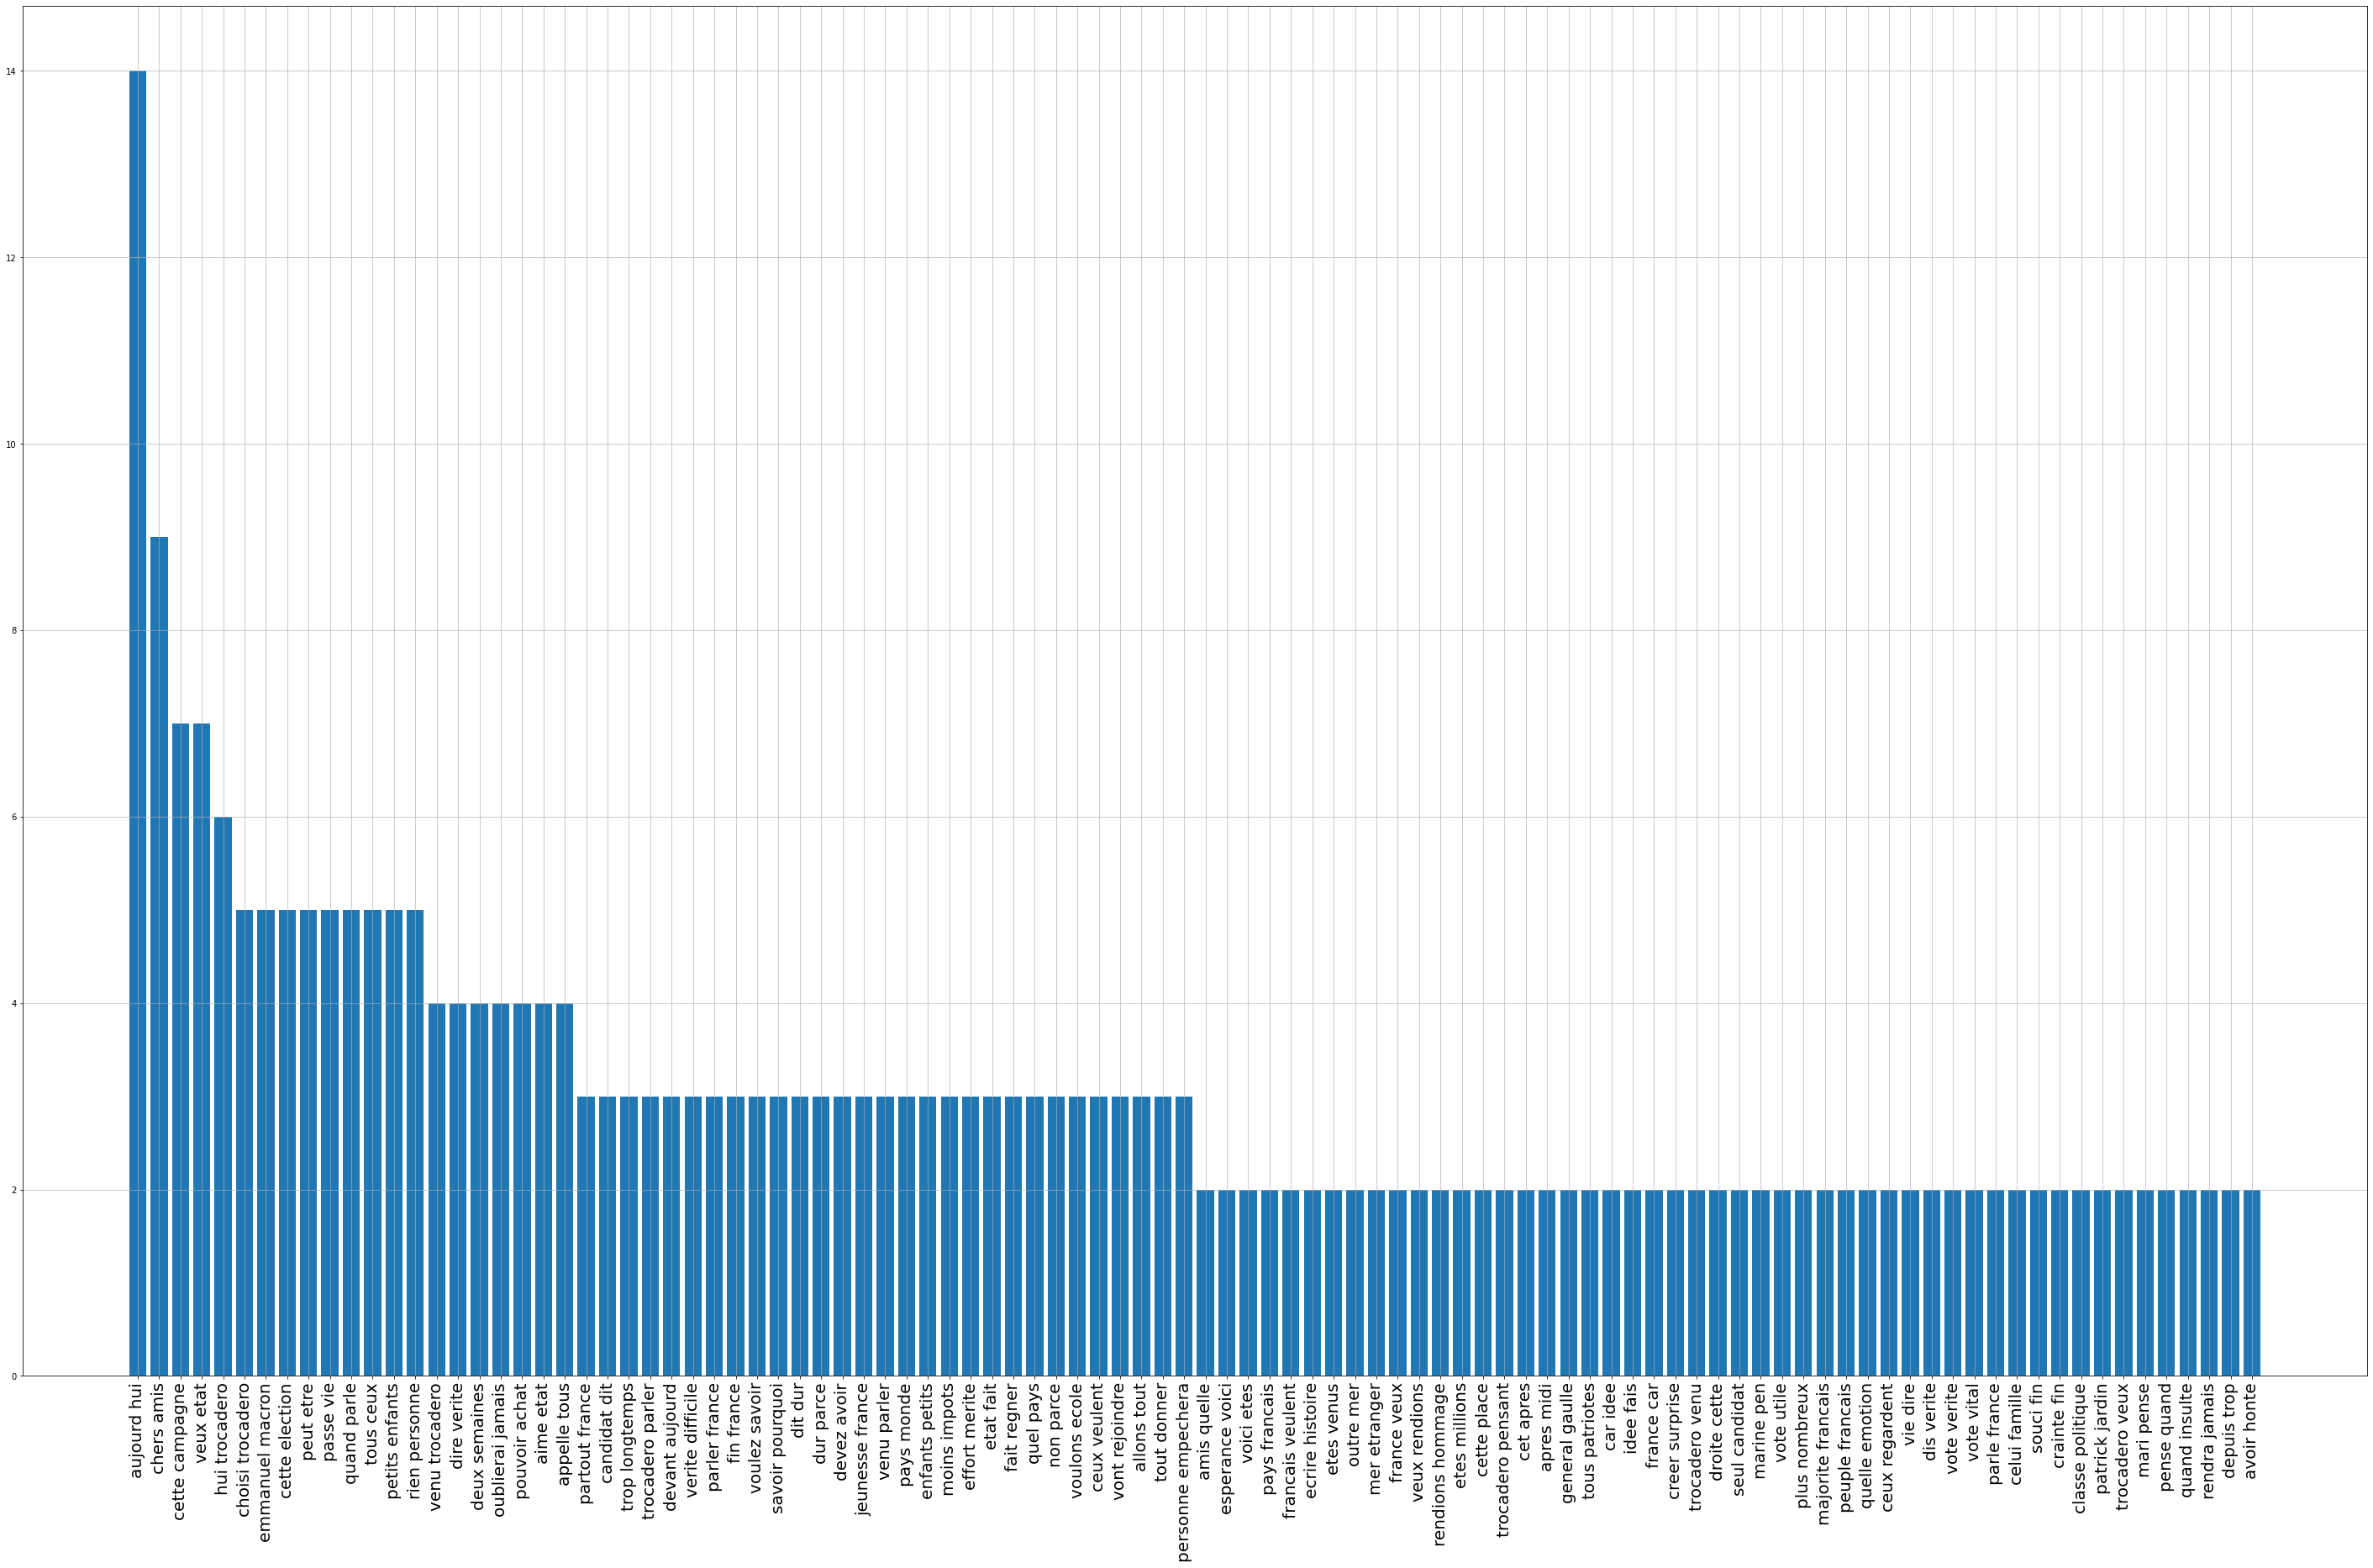

In [57]:
#Récuperer les phrases
sentences=[]
for i in base_recapitulative.Discours:
  sentences.append((i.split(".")))
#Développer bigrams pour les discours
bigram_speech = []
speechtot=[]
speeches = base_recapitulative.Discours
for speech in speeches:
    speech = re.sub(r'\b\w{1,2}\b', '', speech)
    speech = re.sub(r'[^\w]', ' ', speech)
    speech_bigrams = (bigrams(word_tokenize(speech)))
    speechtot.append(word_tokenize(speech))
    
#conversion des  bigram 
for bigram in speech_bigrams:
    bigram = ' '.join(bigram) 
    bigram_speech.append(bigram)
speech_bigrams
#Calculer la fréquence des bigrams
bi_grams_freq = FreqDist(bigram_speech)
mostCommonBigrams= bi_grams_freq.most_common(100)

bigram1 = [bigram[0] for bigram in mostCommonBigrams]
count1 = [bigram[1] for bigram in mostCommonBigrams]
# Affichage de la fréquence des bigrams
plt.figure(figsize=(50,30))
plt.bar(bigram1,count1)
plt.xticks(rotation='vertical', size=20)
plt.grid(True, lw = 0.65)
plt.show()

A part "aujourd'hui" qui n'est pas un vrai bigramme nous pouvons voir rapidement gràave à ce graphique les thèmes qui seront exquissés par la suite

###Statistiques descriptives par discours

Exemple avec le discours d'Agen, modulable

In [58]:
#Fréquence des mots dans chaque discours
speech_fdist = {}
fdist = FreqDist()
for speech in base_recapitulative["Discours"]:
    nom_speech=list(base_recapitulative["Ville"].loc[base_recapitulative["Discours"]==speech])[0]
    for sentence in sent_tokenize(speech):
        sentence = re.sub(r'\b\w{1,2}\b', '', sentence)
        sentence = re.sub(r'[^\w]', ' ', sentence)
        for word in word_tokenize(sentence):
            if word not in stopwords_: 
                fdist[word] += 1
    speech_fdist[nom_speech]=fdist
    fdist = FreqDist()

(speech_fdist["Trocadero"]).most_common(10),(speech_fdist["Saulieu"]).most_common(10)

([('france', 66),
  ('francais', 41),
  ('pays', 34),
  ('plus', 32),
  ('cette', 25),
  ('veux', 24),
  ('parce', 23),
  ('alors', 23),
  ('etes', 21),
  ('tous', 21)],
 [('veux', 44),
  ('france', 39),
  ('plus', 37),
  ('état', 29),
  ('alors', 25),
  ('etat', 24),
  ('comme', 23),
  ('français', 20),
  ('tout', 19),
  ('car', 19)])

(array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]),
 <a list of 9 Text major ticklabel objects>)

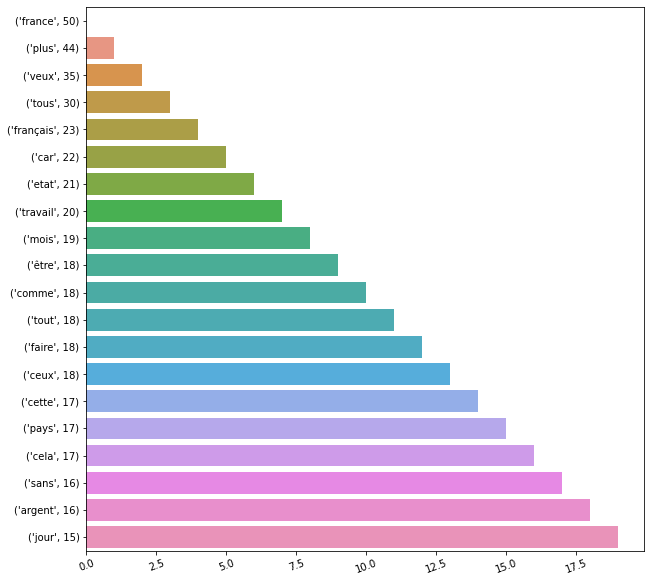

In [59]:
all_fdist=speech_fdist["Agen"].most_common(20)
all_fdist = pd.Series((all_fdist))

fig, ax = plt.subplots(figsize=(10,10))

#Affichage diagramme en baton de la fréquence des termes
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=20)

###LDA

Cette première partie exploratoire doit permettre

- d'apporter des éléments de statistiques descriptives sur la fréquence des mots utilisés dans notre corpus total

- de trouver des grands axes thématiques dans l'ensemble du discours

Idéalement nous aimerions trouver trois ou quantre grands axes dont l'occurence sera ensuite fortement corrélée avec les clusters que nous réaliserons par la suite.

In [60]:
from gensim.models import LdaModel
from gensim import corpora


!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

### Changer la tokenization
tok = RegexpTokenizer(r'\w+')

text_data = list(base_recapitulative["Discours"].apply(lambda x: list(filter(lambda a: a.lower() not in stopwords_ and len(a)>1,tok.tokenize(x)))).array)
#[i.lower() for i in texte4.split() if i not in stopwords and len(i)>1] 
#list(df.content.apply(lambda x: list(filter(lambda a: a.lower() not in stopwords,tok.tokenize(x)))).array)
nb_clusters=3

####

dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]

ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=nb_clusters)
lda_display = gensimvis.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [61]:
b1=lda_display[0]
b2=lda_display[1]
b3=lda_display[2]


b2["%"]=b2["Freq"]/b2["Total"]
b2["%"]

dico_groupe={}

for nom_topics in ["Topic{}".format(i) for i in range(1,nb_clusters+1)]:
  base_topics=b2.loc[b2["Category"]==nom_topics].sort_values(by="%",ascending=False)

  dico_groupe[nom_topics]=list(base_topics["Term"][0:15])

In [62]:
for i in range(1,nb_clusters+1):
  print("Topic{}".format(i),list(dico_groupe.values())[i-1])

Topic1 ['vôtre', 'prime', 'idéologue', 'folles', 'ouvriers', 'martine', 'dépenses', 'nets', 'payez', 'ouvrier', 'revenu', 'moyenne', 'vivez', 'verser', 'isoloir']
Topic2 ['calais', 'commission', 'symbolique', 'europe', 'natalité', 'européenne', 'cher', 'rurale', 'hâte', 'dilapidé', 'sacrifice', 'tragique', 'leçons', 'dédain', 'paix']
Topic3 ['globe', 'cicatrices', 'agroalimentaire', 'leçon', 'abstraction', 'probablement', 'viande', 'guise', 'vendéens', 'pensé', 'vendée', 'miracle', 'remémore', 'fou', 'passée']


L'interprétation ne peut se faire qu'à l'oeil nu car le champ lexical associé à chacun des axes n'est pas obtenu de façon déterministe. Néanmoins nous avons pu dégager des thèmes comme l'Europe, l'école, l'économie, la souveraineté, le pouvoir d'achat, la ruralité, les femmes lors de nos nombreuses expérimentations. Parfois deux de ces thèmes sont hybridés dans un même axe.

#Clustering

Nous pensons que nous pouvons regrouper les discours selon deux axes : géographiques et temporels.

Nous regardons les deux dichotomies pour créer deux clusters par dimension

In [63]:
#National=["Lille","Femmes","Presse","Défense"]

Rural=["Chateaudun","Saintquentin","Saulieu","Sologne"," Chambery","Agen"]+["Lille"]
### Thèmes attendus: pouvoir d'achat, ruralité, éducation

Droite=["Villepinte","Montsaintmichel","Calais","Sables","Cannes","Toulon","Trocadero"]+["Femmes","Presse","Défense"]

### Thèmes attendus: immigration, sécurité

Début_campagne=['Villepinte','Chateaudun','Sables_dolonnes',"Presse",'Saintquentin','Calais','Cannes','Sologne']

Fin_campagne=["Agen",'Chambery','Lille', 'Montsaintmichel','Saulieu',"Toulon","Femmes", "Défense","Trocadero"]

In [64]:
base_debut=base_recapitulative.loc[base_recapitulative["Ville"].isin(Début_campagne)]
base_fin=base_recapitulative.loc[base_recapitulative["Ville"].isin(Fin_campagne)]
base_rurale=base_recapitulative.loc[base_recapitulative["Ville"].isin(Rural)]
base_droite=base_recapitulative.loc[base_recapitulative["Ville"].isin(Droite)]
nb=0

Dico_cluster={}
for base in [base_debut,base_fin,base_rurale,base_droite]:

  nom_base = ["Contexte début","Contexte fin","Contexte rural","Contexte droite"][nb]
  texte=[]
  for i in range(len(base)):
    texte="".join(base["Discours"].iloc[i])+" "
  Dico_cluster[nom_base]=texte
  nb+=1

In [65]:
cle1=list(Dico_cluster.keys())[0]
cle2=list(Dico_cluster.keys())[1]
cle3=list(Dico_cluster.keys())[2]
cle4=list(Dico_cluster.keys())[3]

texte1=list(Dico_cluster.values())[0]
texte2=list(Dico_cluster.values())[1]
texte3=list(Dico_cluster.values())[2]
texte4=list(Dico_cluster.values())[3]

texte1

'mesdames  messieurs  journalistes   premiers  derniers vœux   presse  candidat  élection présidentielle aimerais  dire quelques mots   an jour  jour   inviterai  élysée   relations   plus  mêmes   adresserez    respect admiration sollicitude  hypocrisie comme   faites toujours   présidents   république  malgré  sens aigu     gravité   très hautes fonctions   répondrai   sympathie  rompra  manière éclatante   style   prédécesseur cet illustre emmerdeur selon autoportrait  dresse     reconnaissons   saisissante ressemblance toutefois hélas  nature isolatrice  pouvoir       président      faudra instaurer entre   distance nécessaire     disiez     habite  fonction  verrons bien   beau être bonapartiste  gaulliste   promets être  moins jupitérien possible   fini  président  répond   manière  plus vide   questions  plus creuses   dialoguerons  débattrons     plus idéologie    dernier mot   interviews présidentielles   france  puis comment pourrais  prendre  haut    a six mois  peine  encor

Nous regardons ici si les nuages de mots par clusters que nous avons créés recoupent les caractéristiques qui ont présidé à notre découpage

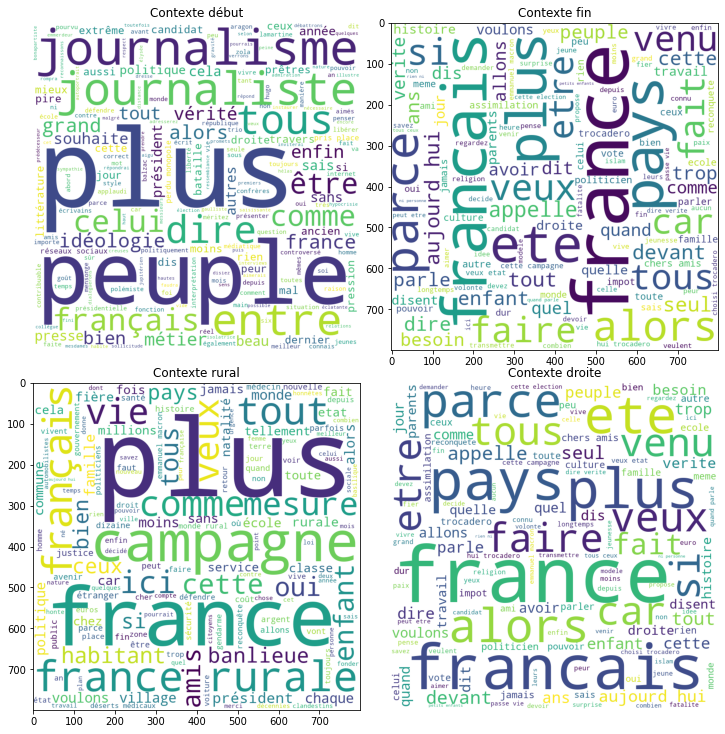

In [66]:
stopwords_=stopwords.words('french')

size=10

wordcloud1 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords_,min_font_size = 10).generate(texte1)
wordcloud2 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords_,min_font_size = 10).generate(texte2)
wordcloud3 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords_,min_font_size = 10).generate(texte3)
wordcloud4 = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stopwords_,min_font_size = 10).generate(texte4)

#figure, (ax1,ax2) = plt.figure(4,figsize = (size, size))
fig, ((ax1, ax2), (ax3, ax4))  = plt.subplots(2,2, figsize=(size,size))


ax1.imshow(wordcloud1)
ax1.set_title(cle1) 

ax2.imshow(wordcloud2) 
ax2.set_title(cle2) 

ax3.imshow(wordcloud3) 
ax3.set_title(cle3) 

ax4.imshow(wordcloud4)
ax4.set_title(cle4) 

ax1.axis("off") 
#ax2.axis("off") 
#ax3.axis("off") 
ax4.axis("off") 



plt.tight_layout(pad = 0) 

plt.savefig("Nuage de mots par clusters attendus.png") 
plt.show() 

Interprétation

####A) Axe temporel
-Nous voyons qu'au début de la campagne les thèmes de journalisme, peuple et idéologie sont plus présents. Il s'agit sans doute de l'entrée en campagne et du passage du journaliste au candidat qui justifient ce champ lexical.
-En fin de campagne (nous rappelons ici que notre coupure est arbitraire) les thèmes de pays et France sont plus représentés.

Cet axe de découpage ne paraît pas très pertinent: beaucoup de petits mots superflus comme les confonctions de coordination ou de subordination ainsi que des adverbes viennent perturber une bonne interprétation

###B) Axe géographique

-Le cluster rural fait ressortir les mots de "campagne", "rural", "banlieue".

-Le cluster "droite" est moins caractérisée par des thématiques identitaires si ce n'est la fréquence importante de France et Français.

Conclusion provisoire: l'axe géographique semble le plus pertinent


In [108]:
import string
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
 


# Preprocessing data to lowercase all words and remove single punctuation words
nb=0
Dico_modele={}
Dico_vocab={}
for text in [texte1,texte2,texte3,texte4]:
  nom_base = ["Contexte début","Contexte fin","Contexte rural","Contexte droite"][nb]

  document=[nltk.word_tokenize(sent) for sent in nltk.sent_tokenize(text)]

  data=[]


  for sent in document:
    new_sent = []
    for word in sent:
      new_word = word.lower()
      if (new_word not in french_stopwords) & (len(new_word)>2):
        new_sent.append(new_word)
        if len(new_word)<3:
          print(new_word)
 
    if len(new_sent) > 1:
      
      data.append(new_sent)

  # Creating Word2Vec
  model = Word2Vec(
  sentences = data,
  size = 200,
  window = 80,
  iter = 60,
  )

### Nous reviendrons sur la justification de la valeur de ces paramètres plus loin: ils n'ont pas été optimisés mais nous avons pu mesurer en quelque
### sorte un indicateur de leur pertinence

  Dico_modele[nom_base]=model
  Dico_vocab[nom_base]=vocab = list(model.wv.vocab.keys())
  nb+=1

In [109]:
Dico_vocab.keys()


set0 = set(Dico_vocab[list(Dico_vocab.keys())[0]])
setA = set(Dico_vocab[list(Dico_vocab.keys())[1]])

setB = set(Dico_vocab[list(Dico_vocab.keys())[2]])
setC = set(Dico_vocab[list(Dico_vocab.keys())[3]])

print(set0 & setA)
print(setB & setC)

print(set0 & setA & setB & setC)

{'alors', 'france', 'comme', 'celui', 'bien', 'tout', 'tous', 'dire', 'enfin', 'plus', 'peuple'}
{'quand', 'pays', 'bien', 'tout', 'plus', 'alors', 'france', 'moins', 'ceux', 'jamais', 'tous', 'veux', 'campagne', 'fait', 'amis', 'voulons', 'vie', 'cette', 'monde', 'etat', 'ici', 'car', 'oui', 'allons', 'peut', 'parce', 'comme', 'enfants'}
{'alors', 'france', 'comme', 'bien', 'tout', 'tous', 'plus'}


In [110]:
voca=[ 'enfants', 'etat', 'monde', 'france', 'amis', 'pays', 'campagne',]
voca_2=['peuple', 'france', 'dire']

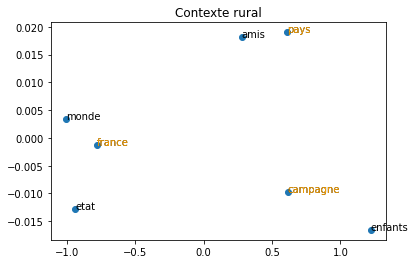

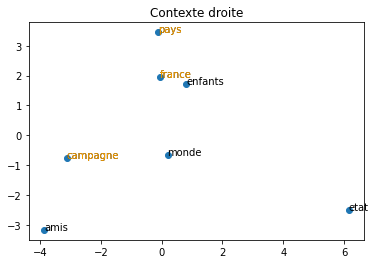

In [111]:
# Finding most similar words

#Visualizing data


for i in ["Contexte rural","Contexte droite"]:
  model=Dico_modele[i]
  X = model.wv[voca]
  pca = PCA(n_components=2)
  result = pca.fit_transform(X)
  
  pyplot.scatter(result[:, 0], result[:, 1])
  for j, word in enumerate(voca):
      pyplot.annotate(word, xy=(result[j, 0], result[j, 1]))
      if word in ["campagne","france","pays"]:
        pyplot.annotate(word, xy=(result[j, 0], result[j, 1]),color="orange")
  plt.title(i)

  plt.show()


Il est intéressant de mesurer la distance entre les mots "France", "Campagne" et "pays"

a) Dans le contexte rural: "pays" est un peu plus proche de "campagne" que de "France"

b) Dans le contexte "droite", "pays" est très fortement associé à "France"

Idem les "enfants" sont plus proches de la campagne dans le contexte rural et plus proche de la France dans le contexte de "droite".

Notre découpage manuel semble donc plutôt pertinent

In [95]:
for w in ["france"]:
  for i in list(Dico_modele.keys()):
    model=Dico_modele[i]
    
    print("Associations pour \"", w,"\":",i)
    words = model.most_similar(w, topn=10)
    for word in words:
      print(word)
    print("______________________________")


Associations pour " france ": Contexte début
('journalistes', 0.999879002571106)
('journalisme', 0.9998716115951538)
('plus', 0.9998603463172913)
('français', 0.9998555779457092)
('idéologie', 0.9998531341552734)
('tous', 0.999843955039978)
('comme', 0.9998421669006348)
('peuple', 0.9998412132263184)
('dire', 0.9998373985290527)
('être', 0.9998365640640259)
______________________________
Associations pour " france ": Contexte fin
('pays', 0.9982472658157349)
('dis', 0.998175323009491)
('ans', 0.9960100650787354)
('francais', 0.9950418472290039)
('parle', 0.9945132732391357)
('enfants', 0.9944986701011658)
('longtemps', 0.9931703805923462)
('petits', 0.9923168420791626)
('histoire', 0.9920668601989746)
('plus', 0.9918073415756226)
______________________________
Associations pour " france ": Contexte rural
('rurale', 0.9999600648880005)
('campagnes', 0.9999599456787109)
('français', 0.9999576807022095)
('vie', 0.9999572038650513)
('alors', 0.9999534487724304)
('plus', 0.9999532699584961)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3

L'analyse des mots proches de "France" selon l'axe géographique et l'axe temporel fait là encore pencher plutôt en faveur d'une analyse spatiale: le cluster rural fait apparaître de fortes similarités entre "France" et les terminologies "rurale", "campagne" et "natalité", le contexte "droite" associe "France" avec "assimilation" et "histoire".

Remarque: beaucoup de mots parasites et inutiles dans notre contexte apparaissent et gènent notre analyse: verbe, adverbe etc...

Le découpage temporel semble moins opérant ici !

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/gensim/matutils.py:737: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if np.issubdtype(vec.dtype, np.int):


[('amis', 0.09183541685342789),
 ('macron', 0.0885404497385025),
 ('fin', 0.08625222742557526),
 ('vie', 0.05910905450582504),
 ('choisi', 0.04789608716964722),
 ('regardez', 0.04682757332921028),
 ('verite', 0.04282122850418091),
 ('emmanuel', 0.029598448425531387),
 ('pense', -0.013649783097207546),
 ('venus', -0.11121392995119095)]

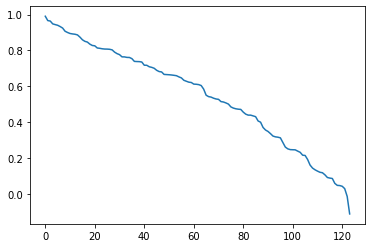

In [119]:
### Cette cellule de code a pour fonction de vérifier la pertinence des paramètres de notre word2vec
### Nous nous sommes en effet rendu compte que les 10 mots les plus similaires avaient en fait un score très proches des mots très lointains
### Nous en déduisons qu'un modèle mal paramétré ne va que corriger à la marge les scores et que la valeur initiale attribuée aléatoirement joue un grand rôle.

model=Dico_modele["Contexte droite"]

exemple=model.most_similar("france", topn=10000) ### nous mettons ici une valeur excessivement grande pour regarder les mots les plus lointains
similarite=[exemple[i][1] for i in range(len(exemple))]
plt.plot(similarite)
exemple[-10:]

In [72]:
#On va réaliser un clustering à partir de la matrice obtenue par le TD-IDF.
base=base_recapitulative.copy()

In [73]:
Texts = []

for j in (base['Discours']):
   Texts.append(j)  
Texts

['bonjour agen  bonjour  chers amis bonjour  nouvelle aquitaine  quel plaisir quel plaisir être  retour   sud ouest    agen depuis    enfant   rugby   cette grande équipe  gaillards fiers  valeureux  affrontent  meilleures équipes   france entière   agen  cette terre chaleureuse où  fait bon vivre  où  beauté  paysages a égal   richesse   gastronomie  agen  hospitalité   chaleur  agenais  merci  accueillir ici chez   chers amis   heureux être   aujourd hui   aujourd hui   grand jour      mars   mois quasiment jour  jour    isoloir  isoloir   rendez   destin   france rendez  avenir   enfants rendez  histoire   pays  isoloir plusieurs bulletins  posés devant    vérité      deux  mien  celui  tous  autres    choix entre  france telle    connaissons   grand saut  inconnu car     autres candidats  proposent   proposent  saut   vide   proposent  france nouvelle comme  disent plus nouvelle  française   proposent  payez  voir    proposent rien   protéger  risques  viennent  chers amis     comm

### Kmeans et td_idf

In [74]:
preprocessed_texts = get_data(Texts)
preprocessed_texts #Un exemple


array(['pourrait matins rester pourrais politiciens pouvoir reconquête mettons agenais connaissons veux particulier atténuantes tax personne artisanat territoire conditionnés villes continue journaliste troublent observation antifas poche plaisir nôtres puisse peux vitesse rêvent tombent sortiez bonjour comptent entendu dehors prennent médecin cadeaux parce avoisinantes progrès beauté mesure réalité celles prison côtés méritez exercer complices presse pourquoi ressortissants essence soucient nationales dites étouffer fin non produisent financerai ni dis près laissez redonner tel emmerder balance france penser retour banque parent djibril notamment payent train bâtisseurs révoltant famille compatriotes pleine entre inconnu investissement développement explose devenu respirateurs fierté rompre élève évoquer méritants passé vision haute système rich tels écoutez art drogue gouvernement facture appauvrit emmanuel shaina facilement massivement particulièrement contre donne achats elles logi

In [75]:
#Définition du modèle TD-IDF 
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_texts)
vocabulary = vectorizer.get_feature_names()
print("Input feature shape : {}".format(X.shape))
X

Input feature shape : (17, 8053)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<17x8053 sparse matrix of type '<class 'numpy.float64'>'
	with 18670 stored elements in Compressed Sparse Row format>

In [76]:
#Affichage de la matrice obtenue, qui représente la fréquence d'apparition d'apparition d'un mot dans un discours en particulier, normalisé par son nombre d'apparition total

print(X.shape)

(17, 8053)


In [77]:
base_recapitulative.head()

,Discours,Ville,date,day,weekday,month,year
0,bonjour agen bonjour chers amis bonjour nou...,Agen,2022-03-12,12,5,3,2022
1,bonjour a tous bonjour amis merci accueil ...,Villepinte,2021-12-05,5,6,12,2021
2,bonjour tous merci présence ici calais d...,Calais,2022-01-19,19,2,1,2022
3,merci amis merci fond cœur presence joi...,Cannes,2022-01-23,23,6,1,2022
4,bonjour chers amis bonjour merci merci mille...,Chambery,2022-02-25,25,4,2,2022


In [78]:
#Application du Kmeans sur la matrice nouvellement obtenue.
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X)
#@title
groupes = kmeans.predict(X)
Villes=base_recapitulative["Ville"]
Dates=base_recapitulative["date"]
results = {
        'Ville' :Villes,
        'Clusters': groupes,
        'Dates':Dates
          }

Clusters_tdidf=pd.DataFrame(results)

In [122]:
Clusters_tdidf.sort_values(by="Clusters")
Clusters_tdidf.sort_values(by="Dates")

,Ville,Clusters,Dates
1,Villepinte,2,2021-12-05
5,Chateaudun,0,2022-01-07
8,Sables,0,2022-01-08
14,Presse,0,2022-01-10
9,Saintquentin,0,2022-01-15
2,Calais,1,2022-01-19
3,Cannes,2,2022-01-23
11,Sologne,0,2022-01-28
6,Lille,0,2022-02-05
10,Saulieu,0,2022-02-12


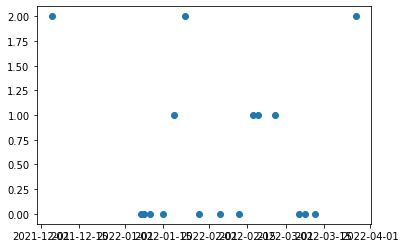

In [80]:
plt.scatter(Clusters_tdidf["Dates"],Clusters_tdidf["Clusters"])


Premier constat: l'analyse temporelle ne semble pas corrélée aux clusters des kmeans

Deuxième constat: 

- un cluster rassemble le premier, le deuxième et le troisième discours d'Eric Zemmour. Les discours de Villepinte, Cannes et du Trocadéro appartiennent au même cluster et font parti des temps forts de la campagne d'Eric Zemmour. Si c'était attendu pour son premier et son dernier discours, c'est moins évident pour Cannes. On peut l'interpréter comme le fait que ces discours très médiatisés étaient en fait addressés à une très large audience de téléspectateurs. Nous qualifierons ce cluster de "national"

- Les disoucrs "Défense", "Chambery", "Calais" et "Montsaintmichel" sont plus tournés vers l'international: géopolitique, immigration (Calais), guerre en Ukraine (Chambéry). Nous regrouperons ce cluster sous le nom d' "international".

- Les autres discours sont regroupés dans un plus grand cluster. Ils s'agit beaucoup de discours en zone rurale et de discous plus thématiques (femmes, presse). Nous qualifierons ce cluster de "rural" ou "social" par comparaison avec les deux autres, même s'il a une dimension un peu fourre-tout.



L'utilisation d'un TD-IDF semble plus judicieux qu'un Word2Vec, du fait d'un échantillon réduit. Les discours de Zemmour nsont pas en nombre suffisant pour envisager l'utilisation d'un word2vec, qui implique un réseau de neurone conséquent.


##Speech Sentiment


On utilise le speech sentiment pour si cette nouvelle dimension corrobore notre classification par cluster ou permet de la corriger et l'affiner.

In [81]:
nltk.download('vader_lexicon')
!pip install vaderSentiment-fr
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
# Assignation des scores de sentiments pour chaque discours
positive_sentiment = []
negative_sentiment = []
neutral_sentiment = []

for speech in base_recapitulative['Discours']:
            sentiment = sid.polarity_scores(speech)
            positive_sentiment.append(sentiment['pos'])
            negative_sentiment.append(sentiment['neg'])
            neutral_sentiment.append(sentiment['neu'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [136]:
#Generation dataframe finale
dict = {'Ville':base_recapitulative.Ville, 'Discours': base_recapitulative.Discours, 
        'Positive_Sentiment':positive_sentiment, 
        'Negative_Sentiment':negative_sentiment, 'Neutral Sentiment': neutral_sentiment}  
        #all_fdist=speech_fdist["Agen"].most_common(20)


df = pd.DataFrame(dict)

df=pd.merge(df,Clusters_tdidf,on="Ville")

### Nous créons ce score pour hiérarchiser les discours entre eux
df["Score sentiment"]=(df["Positive_Sentiment"]-df["Negative_Sentiment"])/df["Neutral Sentiment"]*100
df.sort_values(by="Score sentiment",ascending=False)[["Ville","Score sentiment"]]

#list(df.sort_values(by="Score sentiment",ascending=False)["Ville"])

,Ville,Score sentiment
13,Femmes,10.831234
8,Sables,9.535452
7,Montsaintmichel,7.035176
10,Saulieu,5.889423
12,Toulon,5.109489
9,Saintquentin,4.964539
16,Trocadero,4.715840
14,Presse,4.528764
4,Chambery,4.370861
2,Calais,4.074505


In [ ]:
liste_ville3=df.Ville

#Affichage piplot pour la visualisation des scores de sentiments
labels = 'Positive', 'Negative', 'Neutral'

for i in range(len(df)) :
    pos = (df.iloc[i,2]) * 100
    neg = df.iloc[i,3] * 100
    neu = df.iloc[i,4] * 100
    sizes = [pos, neg, neu]
    fig1, ax1 = plt.subplots()
    plt.title(liste_ville3[i], bbox={'facecolor':'0.8', 'pad':5})

    ax1.pie(sizes, labels=labels, autopct='%1.1f%%')
    ax1.axis('equal')  
plt.show()

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


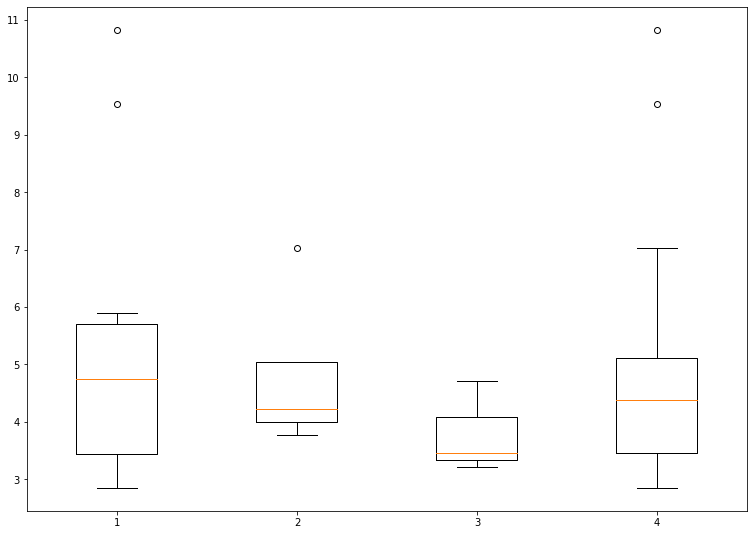

In [83]:
### Quelle corrélation entre clusters et score de sentiment ? Positive mais pas nette 


data_1 = df["Score sentiment"].loc[df["Clusters"]==0]
data_2 = df["Score sentiment"].loc[df["Clusters"]==1]
data_3 = df["Score sentiment"].loc[df["Clusters"]==2]
data_4 = df["Score sentiment"]
data = [data_1, data_2, data_3, data_4]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
# show plot
plt.show()

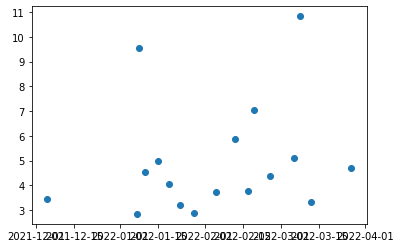

In [130]:
### Pas de corrélation manifeste avec le temps

plt.scatter(df["Dates"],df["Score sentiment"])


Inteprétation de l'analyse par sentiment

- Les clusters kmeans sont corrélés avec le score du sentiment de la manière suivante
a) Les clusters "nationaux" (voire la classification que nous avons fait plus hauts) sont les moins positifs. C'est sans doute lié au message d'Eric Zemmour qui souhauite "sauver la France" des menaces qui pèsent sur elle.
b) Les deux autres clusters ont trop de variance pour être analysés pertinemment

- Nous pouvons classés les discours selon leur note de sentiment positif (celui qu'on a calculé) de la manière suivante

a) Les discours 'Femmes', 'Sables d'Olonnes', 'Montsaintmichel' arrivent largement en premier. C'est sans doute lié à un objectif politique: faire passer une image très positive auprès de l'électorat féminin (déficit dans les intentions de vote), marquer les escprits sur les terres de son soutien Philippe de Villiers en Vendée et mettre en avant le patrimoine historique français au Mont saint Michel.

b) Les discours de Villepinte, Agen	, Cannes, Sologne et Chateaudun	sont les moins positifs, associant sans doute les thématiques nationales de déclin aux problèmes rencontrés par le monde rural

Comme nous n'arrivons pas à bien comprendre dans le plus grand détail ces résultats nous ne les mobiliserons pas dans notre analyse.


#Generation de texte

## Modèle Baseline avec Sentence Encoder TF **Hub**

In [137]:
!pip install bioinfokit

#Chargement de l'Universal Sentence Encoder's TF Hub module

from absl import logging
import tensorflow as tf

import tensorflow_hub as hub


from sklearn.preprocessing import StandardScaler
from bioinfokit.visuz import cluster



module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)
#Calcul d'une représentation pour chaque discours
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(Texts)
message_embeddings1=message_embeddings.numpy()
message_embeddings1

     |████████████████████████████████| 84 kB 3.4 MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-2.0.8-py3-none-any.whl size=56750 sha256=d545bf30c38d4c374d2133f2c5be9e0646d59f26990af29c7e45f1ea1fd19c83
  Stored in directory: /root/.cache/pip/wheels/0d/b0/a4/2be59655e33c889f2197d43e99ed077f05a6559e24ce28e21a
  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7097 sha256=69746b3dd6eea4d83732f5ddcebe83dca8649a32b0e16acb2f71d2ee4d53f143
  Stored in directory: /root/.cache/pip/wheels/2f/98/32/afbf902d8f040fadfdf0a44357e4ab750afe165d873bf5893d
Successfully built bioinfokit adjustText
module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


array([[-0.0115573 , -0.04508106, -0.04504426, ..., -0.04508106,
        -0.04508106,  0.04508103],
       [-0.04714448, -0.04714502, -0.04714463, ..., -0.02776856,
        -0.04714502, -0.04711736],
       [ 0.04433075, -0.04507969, -0.04024085, ..., -0.04507969,
        -0.04507969, -0.04507968],
       ...,
       [-0.00278368, -0.04595922, -0.04595922, ..., -0.04595887,
        -0.04595922, -0.01401394],
       [ 0.04475693, -0.04475693, -0.04047704, ..., -0.04475693,
        -0.04475693,  0.04475693],
       [-0.04616319, -0.04616319, -0.04616316, ...,  0.03642102,
        -0.04616319, -0.04616319]], dtype=float32)

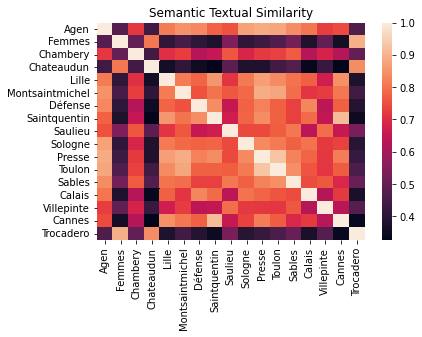

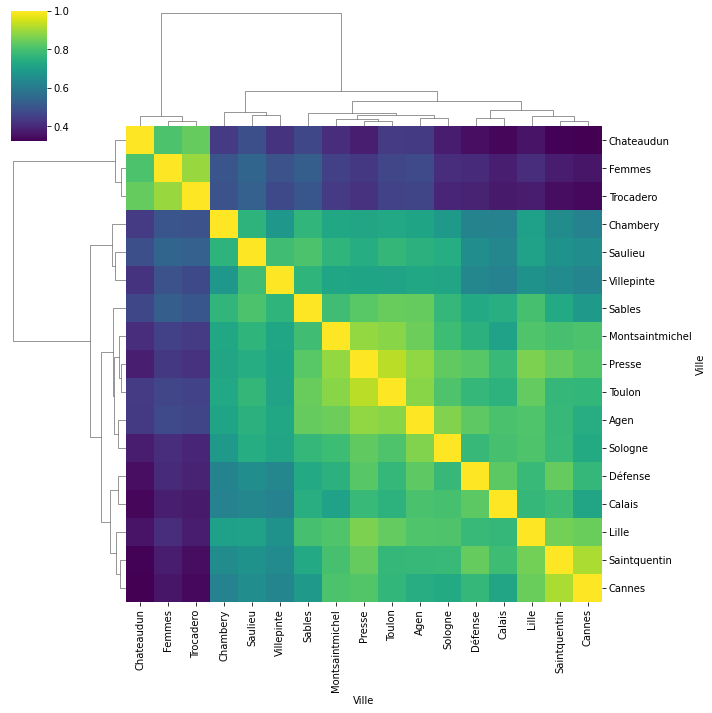

In [138]:
#Réalisation du Kmeans pour la matrice encodée obtenue

SEED = 42

kmeans = KMeans(n_clusters=3, random_state=SEED).fit(message_embeddings1)
base_recapitulative['Clusters']=kmeans.labels_
d=base_recapitulative.sort_values(by="Clusters")
d
corr = np.inner(message_embeddings1, message_embeddings1)
aa=sns.heatmap(corr,xticklabels=d.Ville,yticklabels=d.Ville)
aa.set_title("Semantic Textual Similarity")
  

corr1=pd.DataFrame(corr,index=d.Ville,columns=d.Ville)
#Affichage de la matrice de corrélation entre les discours
clus=sns.clustermap(corr1, cmap = 'viridis', method = 'ward')


##LSTM


To build an LSTM model that predicts words which falls after the end of a sentence .i.e. generates the words which are likely to appear next for a given sentence.

In [139]:
#Importation des bibliotheques
from tensorflow import keras



from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Embedding,Dense,Dropout
import random



base=df3
text=[]
for j in (base['Discours']):
    
   text.append(j)  
# Preprocess pour le LSTM
tokenizer=Tokenizer()

tokenizer.fit_on_texts(text)
word_text=tokenizer.word_index
idx_text=tokenizer.index_word
word_count=tokenizer.word_counts
tot_text=len(word_count)
tot_text
seq=tokenizer.texts_to_sequences(text)


In [140]:
#Création des features et des labels
features=[]
labels=[]

for s in seq:
    for i in range(0,500):
     
       #Obtenir liste de 20 mots
        extract=s[i:i+20]
        features.append(extract[:-1])
        labels.append(extract[-1])

In [141]:
features,labels=shuffle(features,labels,random_state=10)

#Définir ensemble train et test
train_end=int(len(labels)*0.75)

train_feat=features[:train_end]
test_feat=features[train_end:]

train_lab=labels[:train_end]
test_lab=labels[train_end:]

X_train=np.array(train_feat)
X_test=np.array(test_feat)

#Encodage variables cibles
y_train = np.zeros((len(train_lab), tot_text), dtype=np.int8)
y_test = np.zeros((len(test_lab), tot_text), dtype=np.int8)

for example_index, word_index in enumerate(train_lab):
    y_train[example_index, word_index] = 1

for example_index, word_index in enumerate(test_lab):
    y_test[example_index, word_index] = 1

In [142]:
# Un exemple
print("Input:",' '.join([idx_text[i] for i in X_train[1]]))
print("Label:",' '.join([idx_text[train_lab[1]]]))

Input: politiquement correct ici on est vraiment en france c’est le lieu idéal pour vous parler du monde rural pour
Label: décrire


## Building an LSTM model:

In [143]:
#Initialisation du modèle
model=Sequential()

 #Ajouter une couche embeding
model.add(Embedding(input_dim=tot_text,output_dim=100,trainable=True))

#Ajouter le LSTM layer
model.add(LSTM(128, return_sequences=False, dropout=0.1, recurrent_dropout=0.1, activation='tanh'))

#Couche rélu 
model.add(Dense(64,activation='relu'))
#Couche Dropout
model.add(Dropout(0.5))
#Couche final
model.add(Dense(tot_text, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         985900    
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 9859)              640835    
                                                                 
Total params: 1,752,239
Trainable params: 1,752,239
Non-trainable params: 0
_________________________________________________________________


## Execution du modèle

In [144]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.models import save_model
from keras.models import load_model
model = load_model('/content/drive/MyDrive/Projet_NLP_Thibault _Anatole/modele2')
#On charge notre modèle préalablement entraîne plus de 5000 fois.

## Fit du modele sur l'ensemble Train



INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projet_NLP_Thibault _Anatole/mymodel/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Projet_NLP_Thibault _Anatole/mymodel/assets


Epoch 1/2
50/50 [==============================] - 24s 312ms/step - loss: 0.1929 - accuracy: 0.9431 - val_loss: 79.8707 - val_accuracy: 0.0711
Epoch 2/2
50/50 [==============================] - 13s 264ms/step - loss: 0.1755 - accuracy: 0.9451 - val_loss: 80.1326 - val_accuracy: 0.0715


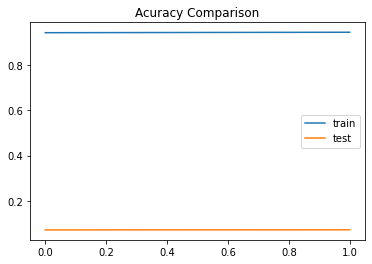

In [145]:
model.save('/content/drive/MyDrive/Projet_NLP_Thibault _Anatole/mymodel')
#Execution du modele, ayant été préalablement été entrainé plus de 5000 fois.
my_model=model.fit(x=X_train,y=y_train,epochs=2,batch_size=128,validation_data=(X_test,y_test))
plt.plot(my_model.history['accuracy'],label='train')
plt.plot(my_model.history['val_accuracy'],label='test')
plt.title("Acuracy Comparison")
plt.legend()
plt.show()

## Generation de texte (prédiction à partir d'extrait de discours).


In [146]:
np.random.seed(10)
seed=20      
new=20

#On choisit une séquence de mots au hasard pour évaluer l'efficacité de notre modèle par un exemple concret.
rand_seq=random.choice(seq)

#On choisit de façon aléatoire le point de départ de notre processus 
start_idx=random.randint(0, len(rand_seq) - seed - 5)

#20 mots après le point de départ.
end_idx=start_idx+seed


#Récupérer l'index de début et de fin
sent=rand_seq[start_idx:end_idx]

#Conversion en mots.
original=[idx_text[i] for i in sent]

#La liste actuelle consiste aux mots originaux associés aux 20 mots le suivant.
actual=sent[:]+rand_seq[end_idx:end_idx+new]

#La liste actuelle consiste aux mots originaux associés aux 20 mots le suivant.
generated=sent[:]

for i in range(new):
    
#Prédiction de la classe de l'extrait étudié.
    
    pred=np.argmax(model.predict(np.array(sent).reshape(1,-1))[0],axis=-1)
    new_idx=np.max(pred)
    sent+=[new_idx]
    generated.append(new_idx)



print("Original:"," ".join(original),"\n")
print("Actual:"," ".join([idx_text[i]for i in actual]),"\n")
print("Generated:"," ".join([idx_text[i]for i in generated]))

Original: perdues balzac a écrit la critique la plus acerbe de votre métier elle n’a pas pris une ride seule a 

Actual: perdues balzac a écrit la critique la plus acerbe de votre métier elle n’a pas pris une ride seule a changé la technologie la presse qu’elle soit écrite ou audiovisuelle est restée le temple du progressisme qu’elle était déjà au temps 

Generated: perdues balzac a écrit la critique la plus acerbe de votre métier elle n’a pas pris une ride seule a plus avoir à céder aux sirènes dernieres annees bordeaux lyon lille nice et dire avec votre collègue quel plaisir de


### Rapprochement avec la clusterisation.

In [147]:
#Nous allons ici reprendre le LSTM travaillé précedemment, mais en ne prenant que les phrases de début de chaque discours.
#Dès lors, nous tenterons de rapprocher la classification en cluster par ces débuts de phrases.

w=[]
np.random.seed(10)
seed=20     
new=50
vi=0 #Incrémentation pour les villes
#On fait une boucle pour représenter chaque discours.
for u in seq:
#On choisit une séquence de mots au hasard pour évaluer l'efficacité de notre modèle par un exemple concret.
  rand_seq=(u)

#On choisit de façon aléatoire le point de départ de notre processus 
  start_idx=0
#20 mots après le point de départ.
  end_idx=start_idx+seed


#Récupérer l'index de début et de fin
  sent=rand_seq[start_idx:end_idx]

#Conversion en mots.
  original=[idx_text[i] for i in sent]

#La liste actuelle consiste aux mots originaux associés aux 20 mots le suivant.
  actual=rand_seq[end_idx:end_idx+new]

#La liste actuelle consiste aux mots originaux associés aux 20 mots le suivant.
  generated=[]

  for i in range(new):
    
#Prédiction de la classe de l'extrait étudié.
    
    pred=np.argmax(model.predict(np.array(sent).reshape(1,-1))[0],axis=-1)
    new_idx=np.max(pred)
    sent+=[new_idx]
    generated.append(new_idx)
  print(liste_ville3[vi])
  print("Cluster",df['Clusters'][vi])
  vi=vi+1
  print("Original:"," ".join(original),"\n")
  print("Actual:"," ".join([idx_text[i]for i in actual]),"\n")
  print("Generated:"," ".join([idx_text[i]for i in generated]))
  w.append([idx_text[z]for z in generated])
  print("_________________________________________")

Agen
Cluster 0
Original: bonjour agen bonjour mes chers amis  bonjour la nouvelle aquitaine quel plaisir quel plaisir d’être de retour dans le sud 

Actual: ouest pour moi agen depuis que je suis enfant c’est le rugby c’est cette grande équipe des gaillards fiers et valeureux qui affrontent les meilleures équipes de la france entière  pour moi agen c’est cette terre chaleureuse où il fait bon vivre et où la beauté des paysages n’a d’égal 

Generated: ouest des quatre et des paysans mais c’est nous qui en moins lointaine et de plus en plus menaçante histoire dans le mort  charette affrontant son exécution avec panache  cadoudal s’opposant à bonaparte… c’est bien si des femmes car je vous en colère ne dit un saut dans le vide ils vous
_________________________________________
Villepinte
Cluster 2
Original: bonjour a tous bonjour mes amis… merci de votre accueil c’est incroyable… quelle ambiance quel bonheur d’etre ici devant vous 

Actual: a villepinte vraiment merci merci du fond du cœu

On peut retrouver dans ces débuts de discours complétés du LSTM des élements communs liés à la clusterisation. 
Par exemple des extraits du discours au Mont Saint-Michel se retrouvent dans l'extrait auto-complété du discours "Défense".
Nous n'avons pas cependant des correspondances exactes. C'est sans doute lié au fait de l'évolution du contexte les derniers mois avec la crise ukrainienne à l'international. Ce contexte tendu a pu provoquer un changement de contenu indépendemment du lieu du discours et la sensibilité politique de celle ci.

 ## Conclusion:

 Nous avons réussi à créer trois clusters cohérents
 - Le cluster national: objectifs politiques avec des grands thèmes structurants de la campagne
 - Le cluster international: quelle place pour la France dans les relations internationales, quelle réponse à l'actualité Ukrainienne etc...
 - Le cluster rural/social: la préoccupation des Français dans leur vie quotidienne